# Introduction

Given a transfer function $h(t)$ [or $H(\omega)$ in the frequency domain], it is sometimes necessary to estimate $h_{inv}(t)$ [or $H_{inv}(\omega)$] to cancel the effect of $h(t)$.

\begin{align*}
X(\omega) \rightarrow \boxed{H_{inv}(\omega)}  \rightarrow \boxed{H(\omega)} \rightarrow Y(\omega)
\end{align*}

where we want to have $Y(\omega)$ resemble $X(\omega)$ as much as possible. This inverse filtering technique is used, for example, for the headphone equalization or room equalization, so that listeners may hear the sound from headphones or loudspeakers without be colored by the device or the room. In this document, a few methods to determine inverse filter are descrbed, implemented and compared.n

In the following text, the response of a headphone (AKG K272) measured on my left ear will be used as an example transfer function, $h(t)$.

In [1]:
# Import necessary packages

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import scipy.fftpack as fft
mpl.rcParams['toolbar'] = 'None'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 15

%config Completer.use_jedi = False

In [2]:
# Define necessary functions

def octave_smooth(fs, H, freq = [], n_octave=3):
    '''
    octave_smooth performs octave-band averaging of spectrum H.
    '''
    
    if len(freq)==0:
        ## Take the positive-frequency part of the frequency response
        H_pos, freq_pos = get_1side_spectrum(H, fs)
    else:
        H_pos = H[freq>=0]
        freq_pos = freq[freq>=0]

    ## 1/n-th octave band smoothing
    temp_H2_avg = np.real(H_pos * np.conj(H_pos))

    H2_avg = np.zeros_like(H_pos, dtype = 'float64')
    for k in np.arange(0, len(freq_pos)):
        fL = freq_pos[k]*2**(-1/(2*n_octave))
        fU = freq_pos[k]*2**(1/(2*n_octave))
        H2_avg[k] = np.mean(temp_H2_avg[(freq_pos>=fL)&(freq_pos<=fU)])
    
    return (np.sqrt(H2_avg), freq_pos)


def get_1side_spectrum(H, fs):
    '''
    This function returns the spectrum from 0 Hz upto and including the Nyquist frequency.
    '''
    
    freq = fs*fft.fftfreq(len(H))
    if np.mod(len(H),2) == 0:
        H_half = H[:(int(len(H)/2) + 1)]
        freq_half = np.abs(freq[:int(len(H)/2 + 1)])
    else:
        H_half = H[:int((len(H)+ 1)/2)]
        freq_half = np.abs(freq[:int((len(H)+ 1)/2)])   

    return H_half, freq_half


def get_2side_spectrum(H_half, nfft):
    '''
    get_2side_spectrum creates the two-sided spectrum,
    given a single-sided spectrum from 0 Hz upto and including the Nyquist frequency,    
    '''
    if np.mod(nfft,2) == 0:
        H = np.hstack((H_half, np.conjugate(np.flipud(H_half[1:-1]))))  
    else:
        H = np.hstack((H_half, np.conjugate(np.flipud(H_half[1:]))))
    
    return H


def get_fftshift_time(nfft, fs):
    if np.mod(nfft,2) == 0:
        timeVec = np.hstack((np.arange(-int(nfft/2), 0)/fs, np.arange(0, int(nfft/2))/fs))
        #idxTimeZero = int(nfft/2)
    else:
        timeVec = np.hstack((np.arange(-int((nfft-1)/2), 0)/fs, np.arange(0, int((nfft+1)/2))/fs))
        #idxTimeZero = int((nfft-1)/2)

    return timeVec

In [3]:
# Load the example transfer function

temp = np.load('MHP_AKG_Left3_Data_FR_IR.npz')
IR = temp['h']
FR = temp['H']
t = temp['t']
freq = temp['f']
fs = temp['fs']
boolFreq1S = freq>=0

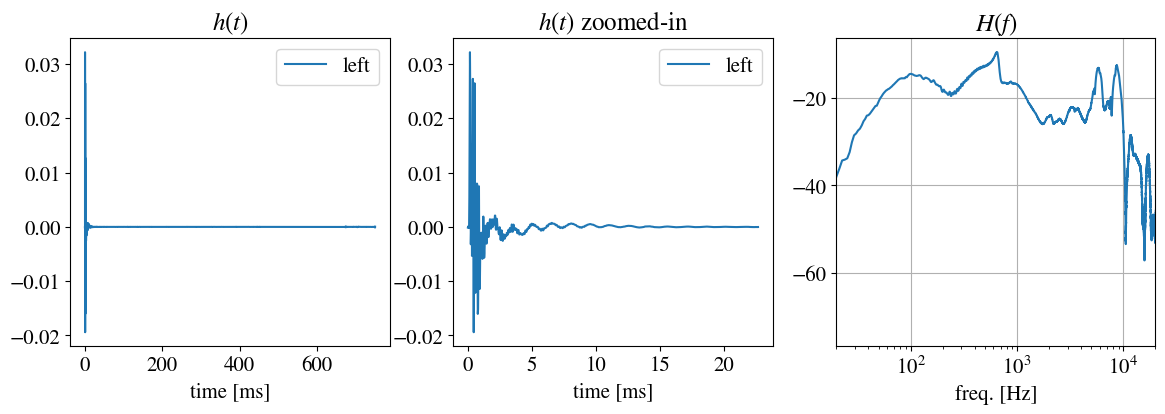

In [4]:
# Plot

fig, ax = plt.subplots(ncols = 3, figsize = [14, 4])

ax[0].plot(t*1e3, IR)
ax[0].set_xlabel('time [ms]')
ax[0].legend(['left', 'right'])
ax[0].set_title('$h(t)$')
ax[1].plot(t[:1000]*1e3, IR[:1000])
ax[1].set_xlabel('time [ms]')
ax[1].legend(['left', 'right'])
ax[1].set_title('$h(t)$ zoomed-in')
ax[2].semilogx(freq[boolFreq1S], 20*np.log10(np.abs(FR[boolFreq1S])))
ax[2].set_xlim([20, 20000])
ax[2].set_xlabel('freq. [Hz]')
ax[2].grid()
ax[2].set_title('$H(f)$')
plt.show()

# Inverse filter construction

## Method 1: Direct inversion

\begin{align*}
H_{inv,direct}(\omega) = \frac{1}{H(\omega)}.
\end{align*}

In [5]:
# Direct inversion

H_inv_direct = 1 / FR
h_inv_direct = fft.ifft(H_inv_direct).real

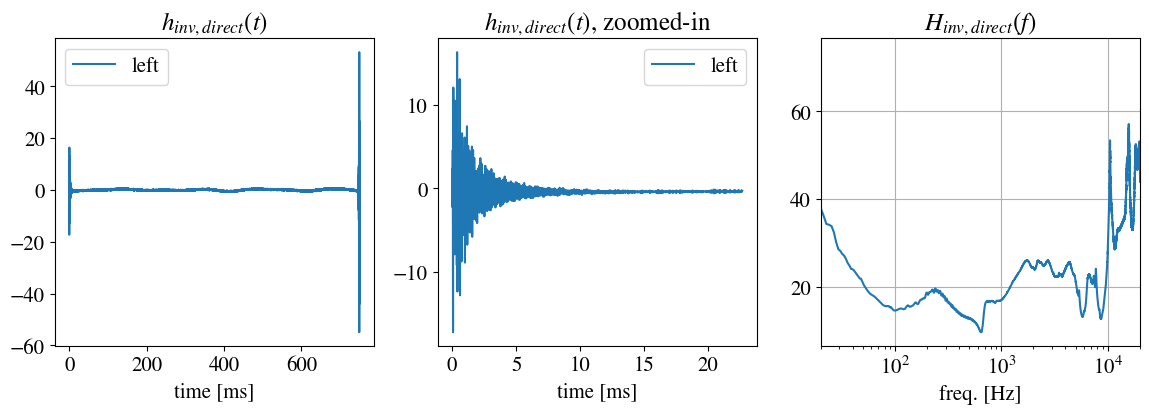

In [6]:
# Plot

fig, ax = plt.subplots(ncols = 3, figsize = [14, 4])

ax[0].plot(t*1e3, h_inv_direct)
ax[0].set_xlabel('time [ms]')
ax[0].legend(['left', 'right'])
ax[0].set_title('$h_{inv,direct}(t)$')
ax[1].plot(t[:1000]*1e3, h_inv_direct[:1000])
ax[1].set_xlabel('time [ms]')
ax[1].legend(['left', 'right'])
ax[1].set_title('$h_{inv,direct}(t)$, zoomed-in')
ax[2].semilogx(freq[boolFreq1S], 20*np.log10(np.abs(H_inv_direct[boolFreq1S])))
ax[2].set_xlim([20, 20000])
ax[2].set_xlabel('freq. [Hz]')
ax[2].grid()
ax[2].set_title('$H_{inv,direct}(f)$')
plt.show()

Where $H\simeq 0$, for example, at $f = 10$ kHz, $H_{inv,direct}$ apparently shows peaks, which leads to a long impulse response $h_{inv,direct}$. Also, $h(t)$ is not necessarily a minimum-phase system, and therefore, its inverse system may not be causal, which is shown clearly by the pre-ringing part at the end of $h_{inv,direct}$.

**Replotting the noncausal impulse responses wrapped around the time zero**

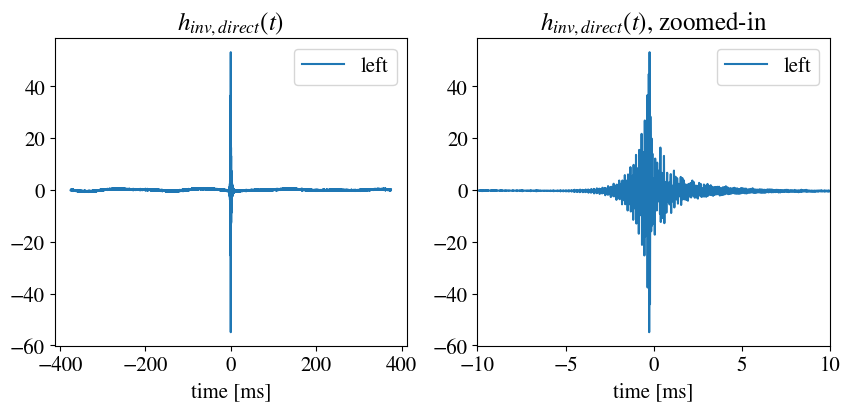

In [7]:
# Plot wrapped-around impulse response

fig, ax = plt.subplots(ncols = 2, figsize = [10, 4])

ax[0].plot(1e3 * get_fftshift_time(len(h_inv_direct), fs), fft.fftshift(h_inv_direct))
ax[0].set_xlabel('time [ms]')
ax[0].legend(['left', 'right'])
ax[0].set_title('$h_{inv,direct}(t)$')
ax[1].plot(1e3 * get_fftshift_time(len(h_inv_direct), fs), fft.fftshift(h_inv_direct))
ax[1].set_xlim([-10, 10])
ax[1].set_xlabel('time [ms]')
ax[1].legend(['left', 'right'])
ax[1].set_title('$h_{inv,direct}(t)$, zoomed-in')
plt.show()

## Method 2: Regularization


\begin{align*}
H_{inv, reg}(\omega) & = \frac{H^\ast (\omega)}{H(\omega)H^\ast (\omega) + \beta(\omega)}\\
\end{align*}

By including a frequency-dependent parameter $\beta$, the denominator on the righthand side is guaranteed to be positive, free of singularities.

### Constant $\beta$

\begin{align*}
H_{inv, reg1}(\omega) & = \frac{H^\ast (\omega)}{H(\omega)H^\ast (\omega) + \beta}\\
\end{align*}

In [8]:
# Example values for beta
maxBeta = (np.abs(FR)**2).mean()/15
betas = np.linspace(0, maxBeta, 4)

# Loop for all beta values
H_inv_reg1 = list()
h_inv_reg1 = list()
for beta in betas:
    H_inv_reg1.append(np.conj(FR) / (np.abs(FR)**2 + beta))
    h_inv_reg1.append(fft.ifft(H_inv_reg1[-1]).real)

H_inv_reg1 = np.array(H_inv_reg1).transpose()
h_inv_reg1 = np.array(h_inv_reg1).transpose()

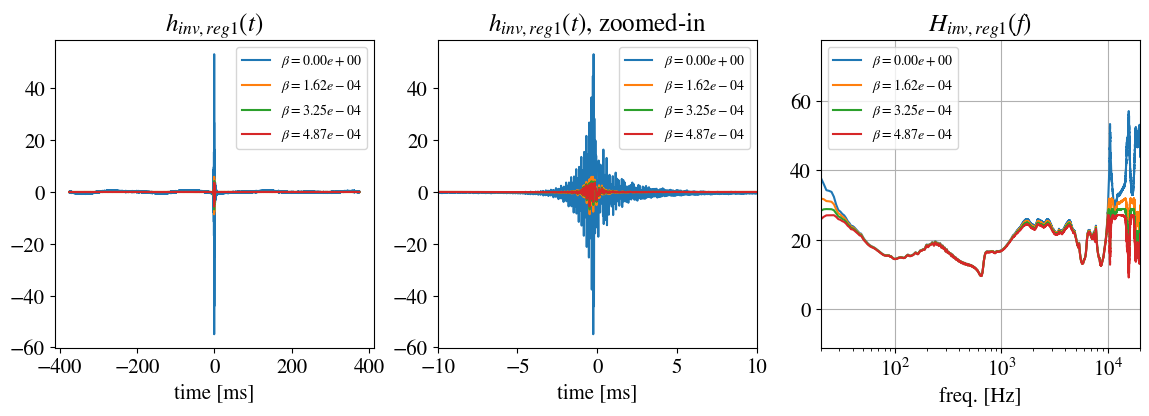

In [9]:
# Plot

fig, ax = plt.subplots(ncols = 3, figsize = [14, 4])

ax[0].plot(1e3 * get_fftshift_time(h_inv_reg1.shape[0], fs), fft.fftshift(h_inv_reg1, axes = 0))
ax[0].set_xlabel('time [ms]')
ax[0].legend(['left', 'right'])
ax[0].set_title('$h_{inv,reg1}(t)$')
ax[0].legend([r'$\beta = %.2e$' % x for x in betas], prop={'size': 10})
ax[1].plot(1e3 * get_fftshift_time(h_inv_reg1.shape[0], fs), fft.fftshift(h_inv_reg1, axes = 0))
ax[1].set_xlim([-10, 10])
ax[1].set_xlabel('time [ms]')
ax[1].legend([r'$\beta = %.2e$' % x for x in betas], prop={'size': 10})
ax[1].set_title('$h_{inv,reg1}(t)$, zoomed-in')
ax[2].semilogx(freq[boolFreq1S], 20*np.log10(np.abs(H_inv_reg1[boolFreq1S,:])))
ax[2].set_xlim([20, 20000])
ax[2].set_xlabel('freq. [Hz]')
ax[2].grid()
ax[2].set_title('$H_{inv,reg1}(f)$')
ax[2].legend([r'$\beta = %.2e$' % x for x in betas], prop={'size': 10})
plt.show()

### Frequency-dependent $\beta$

From $H_{inv,direct}$, it appears that the regularization would benefit mostly the frequency ranges below ~100 Hz and above 9 kHz. Therefore, a frequency-domain window shown below may be multiplied with a constant to construct the function $\beta(\omega)$.

\begin{align*}
H_{inv, reg2}(\omega) & = \frac{H^\ast (\omega)}{H(\omega)H^\ast (\omega) + \beta(\omega)}\\
\end{align*}

In [10]:
idxFreqLo = np.argmin(np.abs(freq - 100))
idxFreqHi = np.argmin(np.abs(freq - 9000))

nFFT = len(H_inv_direct)

if np.mod(nFFT,2) == 0:
    W = np.ones(int(nFFT/2) + 1)
else:
    W = np.ones(int((nFFT+1)/2))

W[idxFreqLo:idxFreqHi] = 0

if np.mod(nFFT,2) == 0:
    W = np.hstack((W, np.flipud(W[1:-1])))
else:
    W = np.hstack((W, np.flipud(W[1:])))

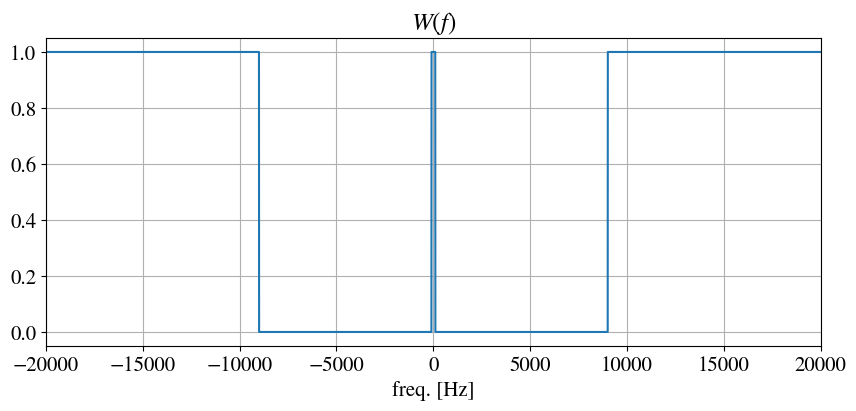

In [11]:
# Plot frequency-domain window

fig, ax = plt.subplots(ncols = 1, figsize = [10, 4])

ax.plot(np.hstack((freq[~boolFreq1S], freq[boolFreq1S])), np.hstack((W[~boolFreq1S], W[boolFreq1S])))
ax.set_xlim([-20000, 20000])
ax.set_xlabel('freq. [Hz]')
ax.grid()
ax.set_title('$W(f)$')
plt.show()

In [12]:
# Example values for beta
maxBeta = (np.abs(FR)**2).mean()/15
betas = np.linspace(0, maxBeta, 4)

# Loop for all beta values
H_inv_reg2 = list()
h_inv_reg2 = list()
for beta in betas:
    H_inv_reg2.append(np.conj(FR) / (np.abs(FR)**2 + beta*W))
    h_inv_reg2.append(fft.ifft(H_inv_reg2[-1]).real)

H_inv_reg2 = np.array(H_inv_reg2).transpose()
h_inv_reg2 = np.array(h_inv_reg2).transpose()

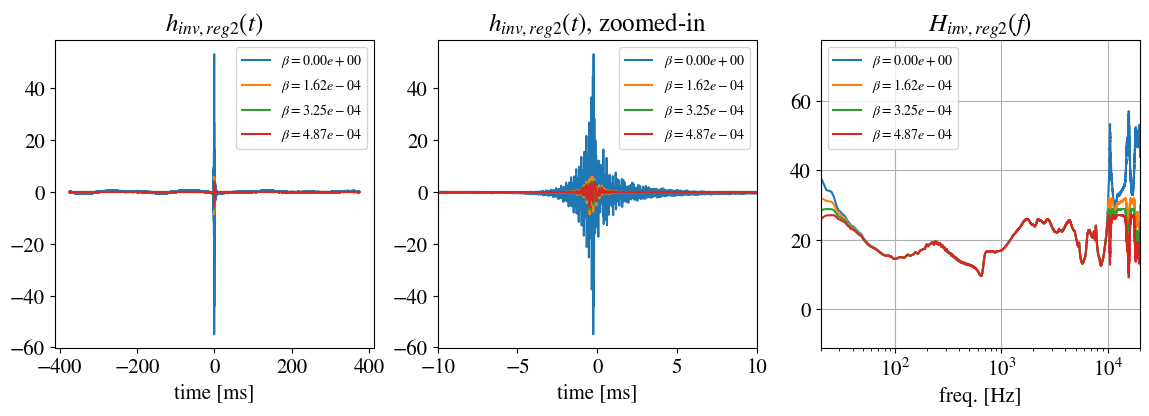

In [13]:
# Plot

fig, ax = plt.subplots(ncols = 3, figsize = [14, 4])

ax[0].plot(1e3 * get_fftshift_time(h_inv_reg2.shape[0], fs), fft.fftshift(h_inv_reg2, axes = 0))
ax[0].set_xlabel('time [ms]')
ax[0].legend(['left', 'right'])
ax[0].set_title('$h_{inv,reg2}(t)$')
ax[0].legend([r'$\beta = %.2e$' % x for x in betas], prop={'size': 10})
ax[1].plot(1e3 * get_fftshift_time(h_inv_reg2.shape[0], fs), fft.fftshift(h_inv_reg2, axes = 0))
ax[1].set_xlabel('time [ms]')
ax[1].set_xlim([-10, 10])
ax[1].legend([r'$\beta = %.2e$' % x for x in betas], prop={'size': 10})
ax[1].set_title('$h_{inv,reg2}(t)$, zoomed-in')
ax[2].semilogx(freq[boolFreq1S], 20*np.log10(np.abs(H_inv_reg2[boolFreq1S,:])))
ax[2].set_xlim([20, 20000])
ax[2].set_xlabel('freq. [Hz]')
ax[2].grid()
ax[2].set_title('$H_{inv,reg2}(f)$')
ax[2].legend([r'$\beta = %.2e$' % x for x in betas], prop={'size': 10})
plt.show()

In the figures above, it is clear that the regularization is NOT performed from 0.1 to 9kHz, which is most noticeable at frequencies 2 to 6 kHz. 

### Frequency-dependent $\beta$, according to (Gomez-Bolanos, 2016)
**"Automatic Regularization Parameter for Headphone Transfer Function Inversion"**

\begin{align*}
H_{inv, reg3}(\omega) & = \frac{H^\ast (\omega)}{|H(\omega)|^2 + \hat{\beta}(\omega)} \\
\hat{\beta}(\omega) & = \alpha (\omega) + \sigma ^ 2 (\omega) \\
\alpha(\omega) & = \frac{1}{\mathrm{SNR}(\omega)} = \frac{|N(\omega)|^2}{|H(\omega)|^2} \\
\sigma & = \left\{
     \begin{array}{lr}
       |H(\omega)| - |\hat{H}(\omega)|, & |\hat{H}(\omega)|\geq|H(\omega)|,\\
       0, & |\hat{H}(\omega)|<|H(\omega)|
     \end{array}
   \right.
\end{align*}

- $N(\omega)$ is the spectrum of the background noise $n(t)$ taken in the end of the 'raw' impulse response.
- $H(\omega)$ is the spectrum of the impulse response $h(t)$ selected from the 'raw' impulse response, of which the length is the same as $n(t)$.
- $\hat{H}(\omega)$ is the smoothened version of $H(\omega)$, where half-octave averaging was taken.

Since $n(t)$ and $h(t)$ need to be of the same length, truncate and window the raw impulse response to get $h(t)$. Then, noise $n(t)$ is selected from the later part of the raw impulse response.


In [14]:
# Truncate the IRs and select the background noise part

lenFilt = 2**13    # Filter length to truncate from t=0. The same length is also taken for the noise.
lenWin = 1024    # Window to apply for smooth tapering-out.
hannWinHalf = np.hanning(2 * lenWin)[-lenWin:]

# Window IR (only in the end)
IRWin = IR[:lenFilt]
IRWin[-lenWin:] = IRWin[-lenWin:] * hannWinHalf

# Window noise (in the beginning and end)
noiseWin = IR[lenFilt:(2*lenFilt)]
noiseWin[:lenWin] = noiseWin[:lenWin] * np.flip(hannWinHalf, axis = 0)
noiseWin[-lenWin:] = noiseWin[-lenWin:] * hannWinHalf

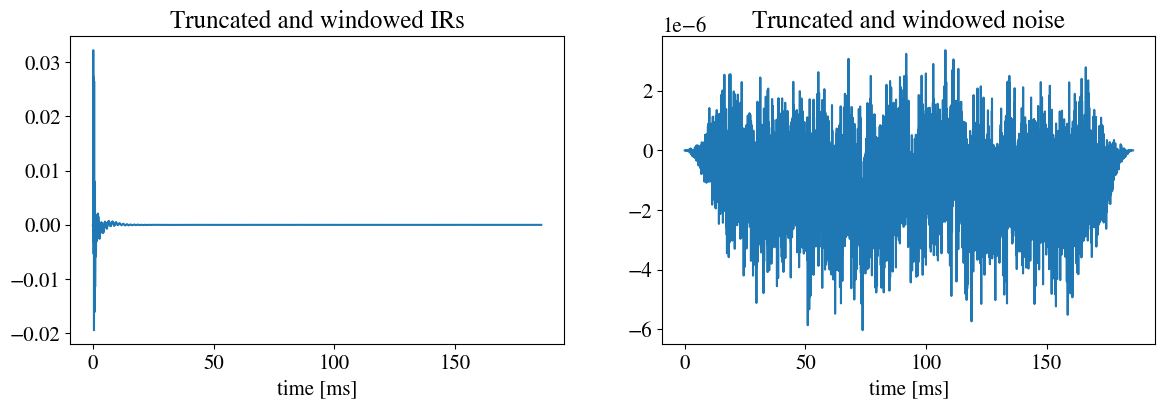

In [15]:
# Plot

fig, ax = plt.subplots(ncols = 2, figsize = [14, 4])
ax[0].plot(t[:lenFilt] *1e3, IRWin)
ax[0].set_xlabel('time [ms]')
ax[0].set_title('Truncated and windowed IRs')
ax[1].plot(t[:lenFilt] * 1e3, noiseWin)
ax[1].set_xlabel('time [ms]')
ax[1].set_title('Truncated and windowed noise')
plt.show()

Now determine $\hat{H}(\omega)$, $\alpha(\omega)$, $\sigma(\omega)$ and $\hat{\beta}(\omega)$.

In [16]:
specH = fft.fft(IRWin)
specN = fft.fft(noiseWin)
specAlpha = np.abs(specN/specH) ** 2
freqNew = fft.fftfreq(len(specH), 1/fs)
boolFreq1SNew = freqNew>=0

# Half-octave smoothing
specHTildePos, freqPos = octave_smooth(fs, specH, n_octave = 2)
specHTilde = get_2side_spectrum(specHTildePos, lenFilt)

sigma = np.abs(specH) - np.abs(specHTilde)
sigma[sigma>0] = 0

betaHat = specAlpha + sigma ** 2

/var/folders/kb/p488q3tx5zq3q4296vy6j14c0000gn/T/ipykernel_61136/3749016451.py:8: RuntimeWarning: divide by zero encountered in log10
  ax[1].semilogx(freqNew[boolFreq1SNew], 10*np.log10(sigma[boolFreq1SNew] ** 2))


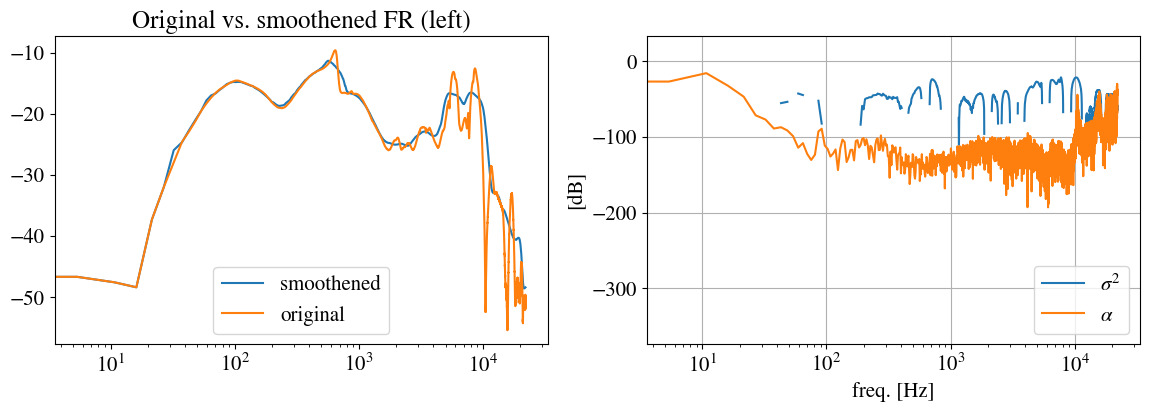

In [17]:
#Plot

fig, ax = plt.subplots(ncols = 2, figsize = [14, 4])
ax[0].semilogx(freqPos, 20*np.log10(np.abs(specHTildePos)))
ax[0].semilogx(freqNew[boolFreq1SNew], 20*np.log10(np.abs(specH[boolFreq1SNew])))
ax[0].legend(['smoothened', 'original'])
ax[0].set_title('Original vs. smoothened FR (left)')
ax[1].semilogx(freqNew[boolFreq1SNew], 10*np.log10(sigma[boolFreq1SNew] ** 2))
ax[1].semilogx(freqNew[boolFreq1SNew], 20*np.log10(specAlpha[boolFreq1SNew]))
ax[1].set_xlabel('freq. [Hz]')
ax[1].set_ylabel('[dB]')
ax[1].legend([r'$\sigma^2$', r'$\alpha$'])
ax[1].grid()
plt.show()

In [18]:
# Determin regularized impulse/frequency response

H_inv_reg3 = np.conj(specH) / (np.abs(specH)**2 + betaHat)
h_inv_reg3 = fft.ifft(H_inv_reg3).real

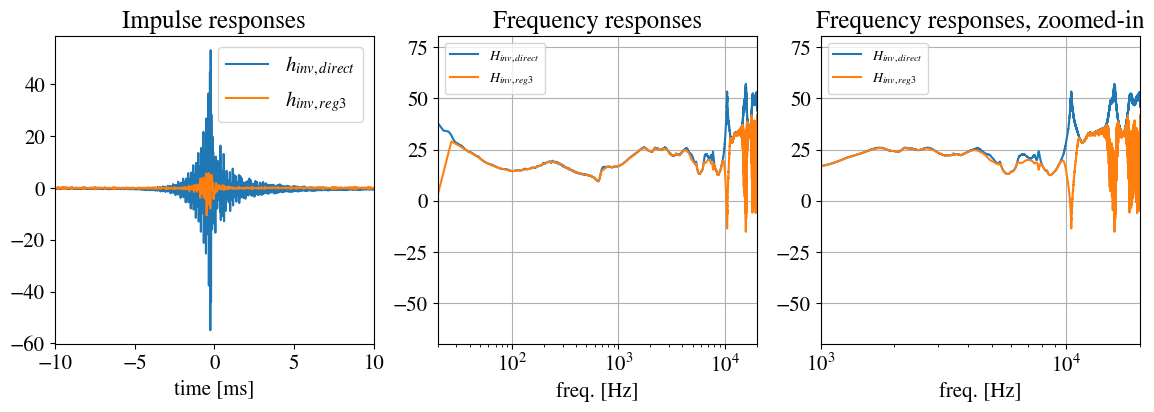

In [19]:
# Plot

fig, ax = plt.subplots(ncols = 3, figsize = [14, 4])

ax[0].plot(1e3*get_fftshift_time(len(h_inv_direct), fs), fft.fftshift(h_inv_direct),
           1e3*get_fftshift_time(len(h_inv_reg3), fs), fft.fftshift(h_inv_reg3))
ax[0].set_xlabel('time [ms]')
ax[0].set_xlim([-10, 10])
ax[0].legend([r'$h_{inv,direct}$', r'$h_{inv,reg3}$'])
ax[0].set_title('Impulse responses')
ax[1].semilogx(freq[boolFreq1S], 20*np.log10(np.abs(H_inv_direct[boolFreq1S])),
               freqNew[boolFreq1SNew], 20*np.log10(np.abs(H_inv_reg3[boolFreq1SNew])))
ax[1].set_xlim([20, 20000])
ax[1].set_xlabel('freq. [Hz]')
ax[1].grid()
ax[1].set_title('Frequency responses')
ax[1].legend([r'$H_{inv,direct}$',
              r'$H_{inv,reg3}$'], prop={'size': 10})
ax[2].semilogx(freq[boolFreq1S], 20*np.log10(np.abs(H_inv_direct[boolFreq1S])),
               freqNew[boolFreq1SNew], 20*np.log10(np.abs(H_inv_reg3[boolFreq1SNew])))
ax[2].set_xlim([1000, 20000])
ax[2].set_xlabel('freq. [Hz]')
ax[2].grid()
ax[2].set_title('Frequency responses, zoomed-in')
ax[2].legend([r'$H_{inv,direct}$',
              r'$H_{inv,reg3}$'], prop={'size': 10})
plt.show()

## Compare all methods

### Inverse filters

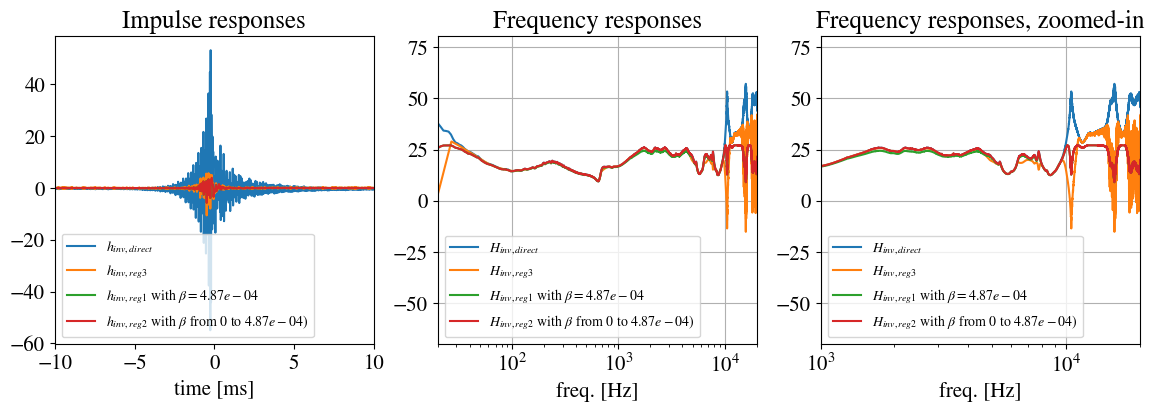

In [20]:
# Plot

fig, ax = plt.subplots(ncols = 3, figsize = [14, 4])

ax[0].plot(1e3*get_fftshift_time(len(h_inv_direct), fs), fft.fftshift(h_inv_direct),           
           1e3*get_fftshift_time(len(h_inv_reg3), fs), fft.fftshift(h_inv_reg3),
           1e3*get_fftshift_time(h_inv_reg1.shape[0], fs), fft.fftshift(h_inv_reg1[:, 3]),
           1e3*get_fftshift_time(h_inv_reg2.shape[0], fs), fft.fftshift(h_inv_reg2[:, 3]))
ax[0].set_xlabel('time [ms]')
ax[0].set_xlim([-10, 10])
ax[0].legend([r'$h_{inv,direct}$',              
              r'$h_{inv,reg3}$',
              r'$h_{inv,reg1}$ with $\beta=%.2e$' % betas[3],
              r'$h_{inv,reg2}$ with $\beta$ from 0 to $%.2e$)' % betas[3]],
              prop={'size': 10})
ax[0].set_title('Impulse responses')
ax[1].semilogx(freq[boolFreq1S], 20*np.log10(np.abs(H_inv_direct[boolFreq1S])),
               freqNew[boolFreq1SNew], 20*np.log10(np.abs(H_inv_reg3[boolFreq1SNew])),
               freq[boolFreq1S], 20*np.log10(np.abs(H_inv_reg1[boolFreq1S,3])),
               freq[boolFreq1S], 20*np.log10(np.abs(H_inv_reg2[boolFreq1S,3])),)
ax[1].set_xlim([20, 20000])
ax[1].set_xlabel('freq. [Hz]')
ax[1].grid()
ax[1].set_title('Frequency responses')
ax[1].legend([r'$H_{inv,direct}$',
              r'$H_{inv,reg3}$',
              r'$H_{inv,reg1}$ with $\beta=%.2e$' % betas[3],
              r'$H_{inv,reg2}$ with $\beta$ from 0 to $%.2e$)' % betas[3]],
              prop={'size': 10})
ax[2].semilogx(freq[boolFreq1S], 20*np.log10(np.abs(H_inv_direct[boolFreq1S])),
               freqNew[boolFreq1SNew], 20*np.log10(np.abs(H_inv_reg3[boolFreq1SNew])),
               freq[boolFreq1S], 20*np.log10(np.abs(H_inv_reg1[boolFreq1S,3])),
               freq[boolFreq1S], 20*np.log10(np.abs(H_inv_reg2[boolFreq1S,3])),)
ax[2].set_xlim([1000, 20000])
ax[2].set_xlabel('freq. [Hz]')
ax[2].grid()
ax[2].set_title('Frequency responses, zoomed-in')
ax[2].legend([r'$H_{inv,direct}$',
              r'$H_{inv,reg3}$',
              r'$H_{inv,reg1}$ with $\beta=%.2e$' % betas[3],
              r'$H_{inv,reg2}$ with $\beta$ from 0 to $%.2e$)' % betas[3]],
              prop={'size': 10})
plt.show()

### Equalized outputs

In [21]:
h_inv_all = [fft.fftshift(h_inv_direct),
             fft.fftshift(h_inv_reg3),
             fft.fftshift(h_inv_reg1[:, 3]),
             fft.fftshift(h_inv_reg2[:, 3])]

from scipy.signal import lfilter

IR_Eq = list()
for h_inv in h_inv_all:
    IR_Eq.append(lfilter(h_inv, 1, IR))

IR_Eq = np.array(IR_Eq).transpose()
FR_Eq = fft.fft(IR_Eq)
freqNew2 = fft.fftfreq(IR_Eq.shape[0], 1/fs)
boolFreq1SNew2 = freqNew2 >= 0

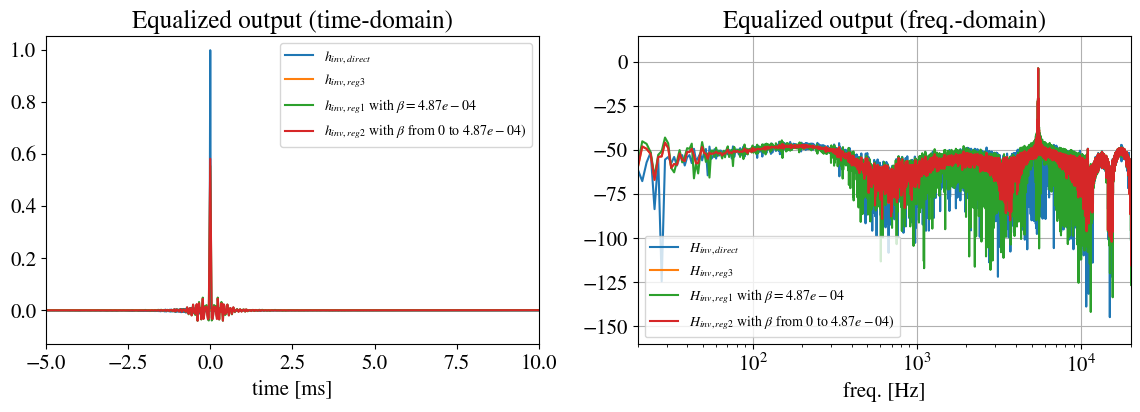

In [22]:
# Plot

fig, ax = plt.subplots(ncols = 2, figsize = [14, 4])

ax[0].plot(1e3*get_fftshift_time(IR_Eq.shape[0], fs), IR_Eq)
ax[0].set_xlabel('time [ms]')
ax[0].set_xlim([-5, 10])
ax[0].legend([r'$h_{inv,direct}$',              
              r'$h_{inv,reg3}$',
              r'$h_{inv,reg1}$ with $\beta=%.2e$' % betas[3],
              r'$h_{inv,reg2}$ with $\beta$ from 0 to $%.2e$)' % betas[3]],
              prop={'size': 10})
ax[0].set_title('Equalized output (time-domain)')
ax[1].semilogx(freqNew2[boolFreq1SNew2], 20*np.log10(np.abs(FR_Eq[boolFreq1SNew2,:])))
ax[1].set_xlim([20, 20000])
ax[1].set_xlabel('freq. [Hz]')
ax[1].grid()
ax[1].set_title('Equalized output (freq.-domain)')
ax[1].legend([r'$H_{inv,direct}$',
              r'$H_{inv,reg3}$',
              r'$H_{inv,reg1}$ with $\beta=%.2e$' % betas[3],
              r'$H_{inv,reg2}$ with $\beta$ from 0 to $%.2e$)' % betas[3]],
              prop={'size': 10})
plt.show()